## Initial setup

In [1]:
## load the packages we will be using
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import mean_squared_error, make_scorer
import xgboost as xgb

In [2]:
## load the datasets
df_store = pd.read_csv("store.csv")
df_test = pd.read_csv("test.csv")
df_train = pd.read_csv("train.csv")

C:\Users\besso\AppData\Local\Temp\ipykernel_2844\2866928819.py:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("train.csv")


In [3]:
## observe a few rows of each dataset
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [4]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,31/07/2015,5263,555,1,1,0,1
1,2,5,31/07/2015,6064,625,1,1,0,1
2,3,5,31/07/2015,8314,821,1,1,0,1
3,4,5,31/07/2015,13995,1498,1,1,0,1
4,5,5,31/07/2015,4822,559,1,1,0,1


In [5]:
df_test.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,4,17/09/2015,NaN,NaN,1.0,1,0,0
1,3,4,17/09/2015,NaN,NaN,1.0,1,0,0
2,7,4,17/09/2015,NaN,NaN,1.0,1,0,0
3,8,4,17/09/2015,NaN,NaN,1.0,1,0,0
4,9,4,17/09/2015,NaN,NaN,1.0,1,0,0


## The store dataset

In [6]:
# observe the store dataset
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


There are 3 nulls we have to deal with in CompetitionDistance and many nulls in CompetitionOpenSinceMonth and CompetitionOpenSinceYear. Since 3 is such a small value, using mean value imputation is an easy fix which will not affect analyses in the big picture. There are too many nulls in the CompetitionOpenSinceMonth, CompetitionOpenSinceYear, Promo2SinceWeek, Promo2SinceYear and PromoInterval columns for us to impute. Such values are also very difficult to impute, as they are dates that we do not know. Hence, we must leave these as they are.

In [7]:
# imputing the missing CompetitionDistance values
CompetitionDistanceMean = df_store['CompetitionDistance'].mean()
df_store['CompetitionDistance'].fillna(CompetitionDistanceMean, inplace = True)

CompetitionOpenSinceMonth and CompetitionOpenSinceYear will be more useful as a single column, giving a single date.

In [8]:
# convert CompetitionOpenSinceMonth and CompetitionOpenSinceYear to a single date column
df_store['CompetitionOpenSinceMonth'] = df_store['CompetitionOpenSinceMonth'].apply(lambda x : str(x)[:-2])
# ensure months are of form '09' instead of '9'
df_store['CompetitionOpenSinceMonth'] = df_store['CompetitionOpenSinceMonth'].apply(lambda x: x.zfill(2))
df_store['CompetitionOpenSinceYear'] = df_store['CompetitionOpenSinceYear'].apply(lambda x : str(x)[:-2])
df_store['CompetitionSinceDate'] = df_store['CompetitionOpenSinceYear'] + "/" + df_store['CompetitionOpenSinceMonth']
# make sure we keep all NaNs where they should be
df_store['CompetitionSinceDate'] = df_store['CompetitionSinceDate'].replace('n/0n', np.nan)

The same concept applies to Promo2SinceWeek and Promo2SinceYear.

While on the topic of Promo2, it is important to note that Promo2 in the store dataset is a different concept to Promo in the train and test datasets. Promo2 is an ongoing coupon campaign, whereas Promo is a store-specific promo on certain days.

In [9]:
# repeat a similar process for Promo2

# first, calculate the month number from the week number
# there are 4.33 weeks in a month on average
df_store['Promo2SinceMonth'] = np.ceil(df_store['Promo2SinceWeek'].div(4.33))

df_store['Promo2SinceMonth'] = df_store['Promo2SinceMonth'].apply(lambda x : str(x)[:-2])
df_store['Promo2SinceMonth'] = df_store['Promo2SinceMonth'].apply(lambda x: x.zfill(2))
df_store['Promo2SinceYear'] = df_store['Promo2SinceYear'].apply(lambda x : str(x)[:-2])
df_store['Promo2SinceDate'] = df_store['Promo2SinceYear'] + "/" + df_store['Promo2SinceMonth']
# make sure we keep all NaNs where they should be
df_store['Promo2SinceDate'] = df_store['Promo2SinceDate'].replace('n/0n', np.nan)

Other useful columns may be the number of months since the nearest competition store opened, or the number of months since stores have been running their Promo2. In order to do this, we need to have a 'current date'. I assume that the current date is 17/09/2015, because this is the last date that appears in the test dataset.

In [10]:
# define the current date
current_date = datetime.datetime(2015, 9, 17)

# create a temporary datetime version of the CompetitionSinceDate column, to be deleted later
df_store['CompetitionSinceDateTemp'] = pd.to_datetime(df_store['CompetitionSinceDate'])

# calculate the difference in months
df_store['MonthsSinceCompetition'] = (current_date - df_store['CompetitionSinceDateTemp']) / pd.Timedelta(days=30.4375)
# round to the nearest whole number
df_store['MonthsSinceCompetition'] = df_store['MonthsSinceCompetition'].round()


# repeat with promos
df_store['Promo2SinceDateTemp'] = pd.to_datetime(df_store['Promo2SinceDate'])
df_store['MonthsSincePromo2'] = (current_date - df_store['Promo2SinceDateTemp']) / pd.Timedelta(days=30.4375)
# round to the nearest whole number
df_store['MonthsSincePromo2'] = df_store['MonthsSincePromo2'].round()

In [11]:
df_store.head(20)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionSinceDate,Promo2SinceMonth,Promo2SinceDate,CompetitionSinceDateTemp,MonthsSinceCompetition,Promo2SinceDateTemp,MonthsSincePromo2
0,1,c,a,1270.0,09,2008,0,NaN,n,NaN,2008/09,0n,NaN,2008-09-01,85.0,NaT,NaN
1,2,a,a,570.0,11,2007,1,13.0,2010,"Jan,Apr,Jul,Oct",2007/11,04,2010/04,2007-11-01,95.0,2010-04-01,66.0
2,3,a,a,14130.0,12,2006,1,14.0,2011,"Jan,Apr,Jul,Oct",2006/12,04,2011/04,2006-12-01,106.0,2011-04-01,54.0
3,4,c,c,620.0,09,2009,0,NaN,n,NaN,2009/09,0n,NaN,2009-09-01,73.0,NaT,NaN
4,5,a,a,29910.0,04,2015,0,NaN,n,NaN,2015/04,0n,NaN,2015-04-01,6.0,NaT,NaN
5,6,a,a,310.0,12,2013,0,NaN,n,NaN,2013/12,0n,NaN,2013-12-01,22.0,NaT,NaN
6,7,a,c,24000.0,04,2013,0,NaN,n,NaN,2013/04,0n,NaN,2013-04-01,30.0,NaT,NaN
7,8,a,a,7520.0,10,2014,0,NaN,n,NaN,2014/10,0n,NaN,2014-10-01,12.0,NaT,NaN
8,9,a,c,2030.0,08,2000,0,NaN,n,NaN,2000/08,0n,NaN,2000-08-01,182.0,NaT,NaN
9,10,a,a,3160.0,09,2009,0,NaN,n,NaN,2009/09,0n,NaN,2009-09-01,73.0,NaT,NaN


PromoInterval is a very awkward column, which is unlikely to give much useful analysis. Every store running promos refreshes their coupons every 3 months, so the only information this column may provide is whether timing of coupon refreshes affects sales. Thinking logically, this will not be an important factor, so we decide to drop it.

Drop all of the other columns we no longer need as well.

In [12]:
# check the values just to make sure we are not missing any useful information
df_store['PromoInterval'].unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [13]:
# drop all of these columns
columns_to_drop = ['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','PromoInterval','Promo2SinceWeek','Promo2SinceYear',
                   'Promo2SinceMonth', 'CompetitionSinceDateTemp', 'Promo2SinceDateTemp']
df_store = df_store.drop(columns_to_drop, axis = 1)

It is worth noting here that the 'b' StoreType stores, and the 'b' Assortment stores make up a small percentage of the total stores. This means that if we include these as dummy variables in a later forecasting model, these 'b' dummy variables will be more sensitive and possibly less reliable as predictors.

Text(0.5, 1.0, 'StoreType Counts')

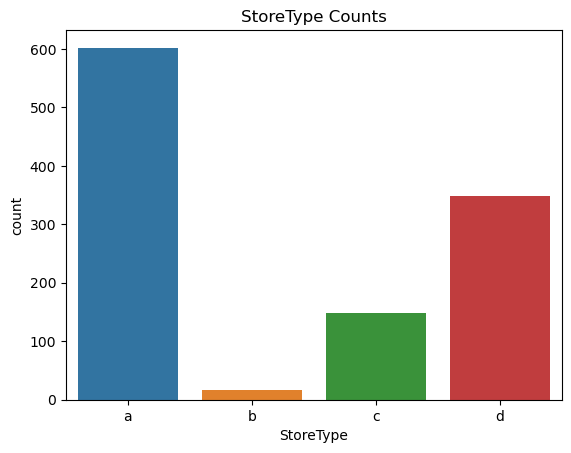

In [14]:
sns.countplot(data = df_store, x = 'StoreType', order = ['a','b','c','d']).set_title('StoreType Counts')

Text(0.5, 1.0, 'Assortment Counts')

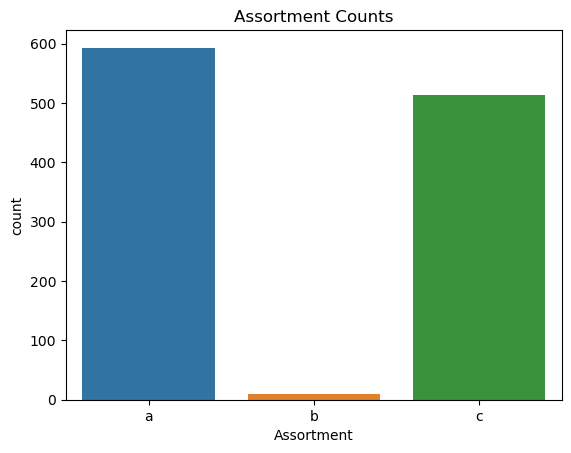

In [15]:
sns.countplot(data = df_store, x = 'Assortment', order = ['a','b','c']).set_title('Assortment Counts')

## The train and test datasets

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [17]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Store          41088 non-null  int64  
 1   DayOfWeek      41088 non-null  int64  
 2   Date           41088 non-null  object 
 3   Sales          0 non-null      float64
 4   Customers      0 non-null      float64
 5   Open           41077 non-null  float64
 6   Promo          41088 non-null  int64  
 7   StateHoliday   41088 non-null  object 
 8   SchoolHoliday  41088 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 2.8+ MB


Null values are not generally an issue with the train and test datasets. The only non-valid null values are in the 'Open' column for the test dataset. We should think about how we want to impute these nulls. Start by observing if day of week determines whether stores are open or not.

Text(0.5, 1.0, 'DayOfWeek vs. Open')

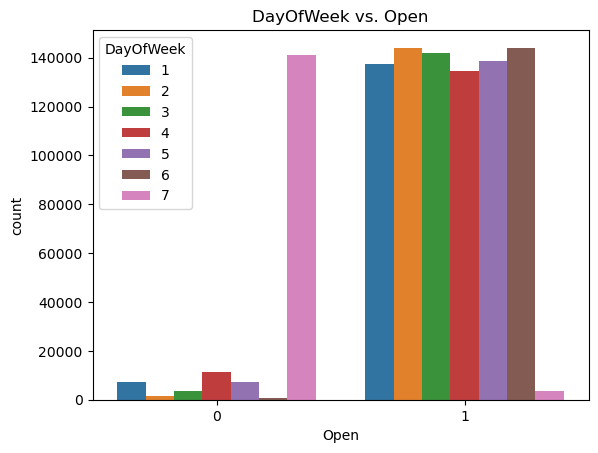

In [18]:
sns.countplot(data = df_train, x = 'Open', hue = 'DayOfWeek').set_title('DayOfWeek vs. Open')

Most shops are closed on Sundays. So impute the nulls with 'Open' = 0 on Sundays, and 'Open' = 1 otherwise.

In [19]:
df_test.loc[df_test['DayOfWeek'] != 7, 'Open'] = df_test.loc[df_test['DayOfWeek'] != 7, 'Open'].fillna(1)
df_test.loc[df_test['DayOfWeek'] == 7, 'Open'] = df_test.loc[df_test['DayOfWeek'] == 7, 'Open'].fillna(0)

Now we look at the 'Date' column in the train dataset. There are stores which are missing records for a certain time period.

In [20]:
# create a temporary version of the Date column, in datetime format
df_train['TempDate'] = pd.to_datetime(df_train['Date'], format='%d/%m/%Y')

# create a dataframe to hold all dates from the minimum to maximum date in the dataset
all_dates = pd.date_range(start=df_train['TempDate'].min(), end=df_train['TempDate'].max(), freq='D')

# group by store and check for missing dates
missing_dates = df_train.groupby('Store')['TempDate'].apply(lambda x: all_dates.difference(x)).reset_index()

# filter out rows with no missing dates
missing_dates = missing_dates[missing_dates['TempDate'].apply(lambda x: len(x) > 0)]

# print stores with missing dates and the dates that are missing
for index, row in missing_dates.iterrows():
    store = row['Store']
    missing_date_list = row['TempDate']
    print(f"Store {store} has missing data on the following dates:")
    print(missing_date_list)

# drop the temporary column
df_train.drop(columns=['TempDate'], inplace=True)

Store 13 has missing data on the following dates:
DatetimeIndex(['2014-07-01', '2014-07-02', '2014-07-03', '2014-07-04',
               '2014-07-05', '2014-07-06', '2014-07-07', '2014-07-08',
               '2014-07-09', '2014-07-10',
               ...
               '2014-12-22', '2014-12-23', '2014-12-24', '2014-12-25',
               '2014-12-26', '2014-12-27', '2014-12-28', '2014-12-29',
               '2014-12-30', '2014-12-31'],
              dtype='datetime64[ns]', length=184, freq=None)
Store 20 has missing data on the following dates:
DatetimeIndex(['2014-07-01', '2014-07-02', '2014-07-03', '2014-07-04',
               '2014-07-05', '2014-07-06', '2014-07-07', '2014-07-08',
               '2014-07-09', '2014-07-10',
               ...
               '2014-12-22', '2014-12-23', '2014-12-24', '2014-12-25',
               '2014-12-26', '2014-12-27', '2014-12-28', '2014-12-29',
               '2014-12-30', '2014-12-31'],
              dtype='datetime64[ns]', length=184, freq=None

In [21]:
len(missing_dates)

181

We can see that 181 stores have some missing dates. The missing dates are generally in the range 2014-07-01 to 2014-12-31. This is a considerable amount of missing data. Unfortunately, we do not know why this data is missing, so it is nearly impossible to impute effectively. 

On the other hand, throughout our analyses, we will generally only be interested in average numbers of sales and customers. Even for this date range where we have missing values, looking at averages will be good enough for our purposes. Thus, we will leave this date range missing.

Now we should discuss whether it is worth keeping records where a store is closed. Whenever a store is closed, sales and customer numbers are automatically 0. Our forecasting model should reflect this explicitly.

If we were interested in looking at the closure patterns of different stores, for example, these records would be useful. However, it is not of much use when trying to predict sales and customer numbers. Hence, we will remove such records from the training dataset before we continue with any analysis.

The 'Open' column will then just be filled with 1s, so drop it.

In [22]:
df_train.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,31/07/2015,5263,555,1,1,0,1
1,2,5,31/07/2015,6064,625,1,1,0,1
2,3,5,31/07/2015,8314,821,1,1,0,1
3,4,5,31/07/2015,13995,1498,1,1,0,1
4,5,5,31/07/2015,4822,559,1,1,0,1


In [23]:
# drop closed days
df_train = df_train.drop(df_train[df_train['Open'] == 0].index)
# drop the 'Open' column
df_train.drop('Open', axis = 1, inplace = True)

Now we look at whether we can modify the 'Date' column. We can create month and year columns, which can be used for visualisations and predictions later. The year column will not be as useful of a column, because the training data we have only spans around two and a half years (01/01/2013 to 31/07/2015). The month column, on the other hand, will be more useful, as we can see how sales and customer numbers change between calendar months.


Also, within the specific dates given in the train dataset (e.g. 31/07/2015), the exact day is not of much relevance. In order to create clearer visualisations, we can drop the day (e.g. 2015/07).

In the test dataset, however, we should keep the full date (e.g. 31/07/2015) because we are trying to make predictions about a specific day, and we are not creating visualisations for this dataset.

In [24]:
# create the year columns
df_train['Year'] = df_train['Date'].apply(lambda x : str(x)[-4:])
df_test['Year'] = df_test['Date'].apply(lambda x : str(x)[-4:])

# create the month columns
df_train['Month'] = df_train['Date'].apply(lambda x : str(x)[3:5])
df_test['Month'] = df_test['Date'].apply(lambda x : str(x)[3:5])

# create the new date column for the train dataset
df_train['Date'] = df_train['Year'] + "/" + df_train['Month']

Take a closer look at the StateHoliday columns.

In [25]:
df_train['StateHoliday'].value_counts()

0    731342
0    112140
a       694
b       145
c        71
Name: StateHoliday, dtype: int64

In [26]:
df_test['StateHoliday'].value_counts()

0    40908
a      180
Name: StateHoliday, dtype: int64

We certainly need to change the 0 integers to '0' strings for the sake of consistency.

In [27]:
df_train.loc[df_train['StateHoliday'] == 0, 'StateHoliday'] = '0'
df_test.loc[df_test['StateHoliday'] == 0, 'StateHoliday'] = '0'

In the test dataset, there are no 'b' (Easter holiday) or 'c' (Christmas) values. It does not make sense to train data using these 'b' and 'c' values, when the data we want to test on does not contain these. We can either:
- Change all 'a', 'b' and 'c' values into a single value 1.
- Remove the training data with values 'b' or 'c'.

In order to decide which is the better option, we should see whether 'b' or 'c' holidays have a noticeably different effect on sales and customers numbers, in comparison to 'a' holidays.

Text(0.5, 1.0, 'Sales vs. StateHoliday Type')

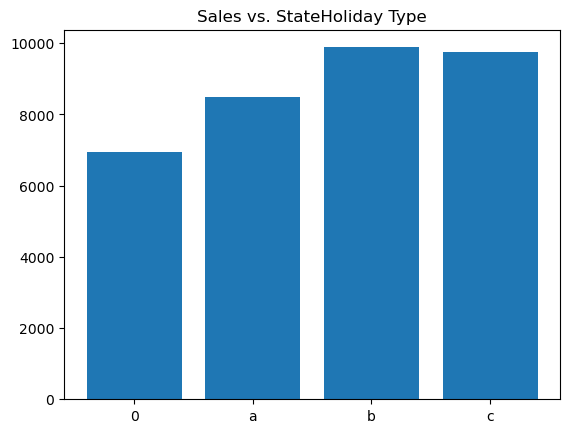

In [28]:
# observe whether sales are better on holidays
avg_sales_holidays = df_train.groupby('StateHoliday')['Sales'].mean()
plt.bar(avg_sales_holidays.index, avg_sales_holidays.values)
plt.title('Sales vs. StateHoliday Type')

Text(0.5, 1.0, 'Customers vs. StateHoliday Type')

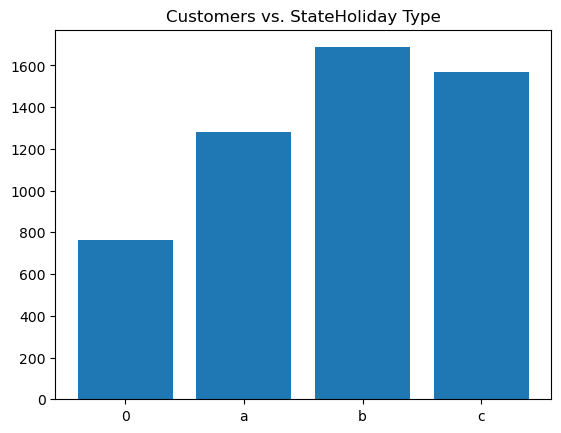

In [29]:
# repeat, but for customers instead of sales
avg_customers_holidays = df_train.groupby('StateHoliday')['Customers'].mean()
plt.bar(avg_customers_holidays.index, avg_customers_holidays.values)
plt.title('Customers vs. StateHoliday Type')

It is clear that 'b' and 'c' type holidays perform better than 'a' type holidays. As mentioned before, keeping the 'b' and 'c' values in our training dataset, when our test dataset has none of these, may affect later predictions negatively, especially now that we know that they have different impacts on sales and customers. Hence, we should ignore all records with the 'b' and 'c' values in them.

In [30]:
df_train.drop(df_train[df_train['StateHoliday'].isin(['b','c'])].index, inplace=True)

Now that we only have values '0' and 'a' in the StateHoliday column, make it binary instead, i.e. 0s and 1s.

In [31]:
df_train.loc[df_train['StateHoliday'] == 'a', 'StateHoliday'] = 1
df_test.loc[df_test['StateHoliday'] == 'a', 'StateHoliday'] = 1

# earlier we changed from integer 0 to string 0, now change it back for consistency
df_train.loc[df_train['StateHoliday'] == '0', 'StateHoliday'] = 0
df_test.loc[df_test['StateHoliday'] == '0', 'StateHoliday'] = 0

There is one final thing to check about the StateHoliday column. I noticed, just by observation, that there are very few state holiday days in comparison to non state holiday days. We should observe the percentage of records in the train dataset which are state holidays, compared to the percentage in the test dataset.

In [32]:
# observe the number of state holiday days in the training dataset
df_train['StateHoliday'].value_counts()

0    843482
1       694
Name: StateHoliday, dtype: int64

In [33]:
# calculate the percentage of these days
(694/(843482 + 694)) * 100

0.08221034476222967

In [34]:
# we are interested in state holiday days, where stores are still open
df_test[df_test['Open'] == 1]['StateHoliday'].value_counts()

0    35078
1       26
Name: StateHoliday, dtype: int64

In [35]:
# calculate the percentage of these days
(26/(35078 + 26)) * 100

0.07406563354603464

These two percentages are relatively similar, which suggests StateHoliday will be a representative variable.

## Merging the train dataset

We merge the store and training dataset so that we can make better visualisations. Once we have finished making visualisations, we will drop the columns that will be of no use in the forecasting model.

In [36]:
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,Promo2,CompetitionSinceDate,Promo2SinceDate,MonthsSinceCompetition,MonthsSincePromo2
0,1,c,a,1270.0,0,2008/09,NaN,85.0,NaN
1,2,a,a,570.0,1,2007/11,2010/04,95.0,66.0
2,3,a,a,14130.0,1,2006/12,2011/04,106.0,54.0
3,4,c,c,620.0,0,2009/09,NaN,73.0,NaN
4,5,a,a,29910.0,0,2015/04,NaN,6.0,NaN


In [37]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Year,Month
0,1,5,2015/07,5263,555,1,0,1,2015,07
1,2,5,2015/07,6064,625,1,0,1,2015,07
2,3,5,2015/07,8314,821,1,0,1,2015,07
3,4,5,2015/07,13995,1498,1,0,1,2015,07
4,5,5,2015/07,4822,559,1,0,1,2015,07


In [38]:
merged_train = df_train.merge(df_store, how = 'left', on = 'Store')
merged_train

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Year,Month,StoreType,Assortment,CompetitionDistance,Promo2,CompetitionSinceDate,Promo2SinceDate,MonthsSinceCompetition,MonthsSincePromo2
0,1,5,2015/07,5263,555,1,0,1,2015,07,c,a,1270.0,0,2008/09,NaN,85.0,NaN
1,2,5,2015/07,6064,625,1,0,1,2015,07,a,a,570.0,1,2007/11,2010/04,95.0,66.0
2,3,5,2015/07,8314,821,1,0,1,2015,07,a,a,14130.0,1,2006/12,2011/04,106.0,54.0
3,4,5,2015/07,13995,1498,1,0,1,2015,07,c,c,620.0,0,2009/09,NaN,73.0,NaN
4,5,5,2015/07,4822,559,1,0,1,2015,07,a,a,29910.0,0,2015/04,NaN,6.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844171,682,2,2013/01,3375,566,0,1,1,2013,01,b,a,150.0,0,2006/09,NaN,109.0,NaN
844172,733,2,2013/01,10765,2377,0,1,1,2013,01,b,b,860.0,0,1999/10,NaN,192.0,NaN
844173,769,2,2013/01,5035,1248,0,1,1,2013,01,b,b,840.0,1,NaN,2012/12,NaN,34.0
844174,948,2,2013/01,4491,1039,0,1,1,2013,01,b,b,1430.0,0,NaN,NaN,NaN,NaN


This dataframe has the columns needed to make all the visualisations which may be useful, so save it as a .csv before moving to Tableau.

In [39]:
merged_train.to_csv("merged_train.csv", index = False)

## Merging the test dataset
We merge the test dataset with the store dataset, as the store dataset contains many variables which will be useful in prediction.

In [40]:
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,Promo2,CompetitionSinceDate,Promo2SinceDate,MonthsSinceCompetition,MonthsSincePromo2
0,1,c,a,1270.0,0,2008/09,NaN,85.0,NaN
1,2,a,a,570.0,1,2007/11,2010/04,95.0,66.0
2,3,a,a,14130.0,1,2006/12,2011/04,106.0,54.0
3,4,c,c,620.0,0,2009/09,NaN,73.0,NaN
4,5,a,a,29910.0,0,2015/04,NaN,6.0,NaN


In [41]:
df_test.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
0,1,4,17/09/2015,NaN,NaN,1.0,1,0,0,2015,09
1,3,4,17/09/2015,NaN,NaN,1.0,1,0,0,2015,09
2,7,4,17/09/2015,NaN,NaN,1.0,1,0,0,2015,09
3,8,4,17/09/2015,NaN,NaN,1.0,1,0,0,2015,09
4,9,4,17/09/2015,NaN,NaN,1.0,1,0,0,2015,09


In [42]:
merged_test = df_test.merge(df_store, how = 'left', on = 'Store')
merged_test

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,StoreType,Assortment,CompetitionDistance,Promo2,CompetitionSinceDate,Promo2SinceDate,MonthsSinceCompetition,MonthsSincePromo2
0,1,4,17/09/2015,NaN,NaN,1.0,1,0,0,2015,09,c,a,1270.0,0,2008/09,NaN,85.0,NaN
1,3,4,17/09/2015,NaN,NaN,1.0,1,0,0,2015,09,a,a,14130.0,1,2006/12,2011/04,106.0,54.0
2,7,4,17/09/2015,NaN,NaN,1.0,1,0,0,2015,09,a,c,24000.0,0,2013/04,NaN,30.0,NaN
3,8,4,17/09/2015,NaN,NaN,1.0,1,0,0,2015,09,a,a,7520.0,0,2014/10,NaN,12.0,NaN
4,9,4,17/09/2015,NaN,NaN,1.0,1,0,0,2015,09,a,c,2030.0,0,2000/08,NaN,182.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,1111,6,01/08/2015,NaN,NaN,1.0,0,0,0,2015,08,a,a,1900.0,1,2014/06,2013/08,16.0,26.0
41084,1112,6,01/08/2015,NaN,NaN,1.0,0,0,0,2015,08,c,c,1880.0,0,2006/04,NaN,114.0,NaN
41085,1113,6,01/08/2015,NaN,NaN,1.0,0,0,0,2015,08,a,c,9260.0,0,NaN,NaN,NaN,NaN
41086,1114,6,01/08/2015,NaN,NaN,1.0,0,0,0,2015,08,a,c,870.0,0,NaN,NaN,NaN,NaN


## Creating visualisations
The majority of visualisations are created in Tableau, using the merged_train dataset above.

Some visualisations, however, are easier to create within Python.

We want to see the effect of promos starting, and nearby competition stores opening on sales and customer numbers.

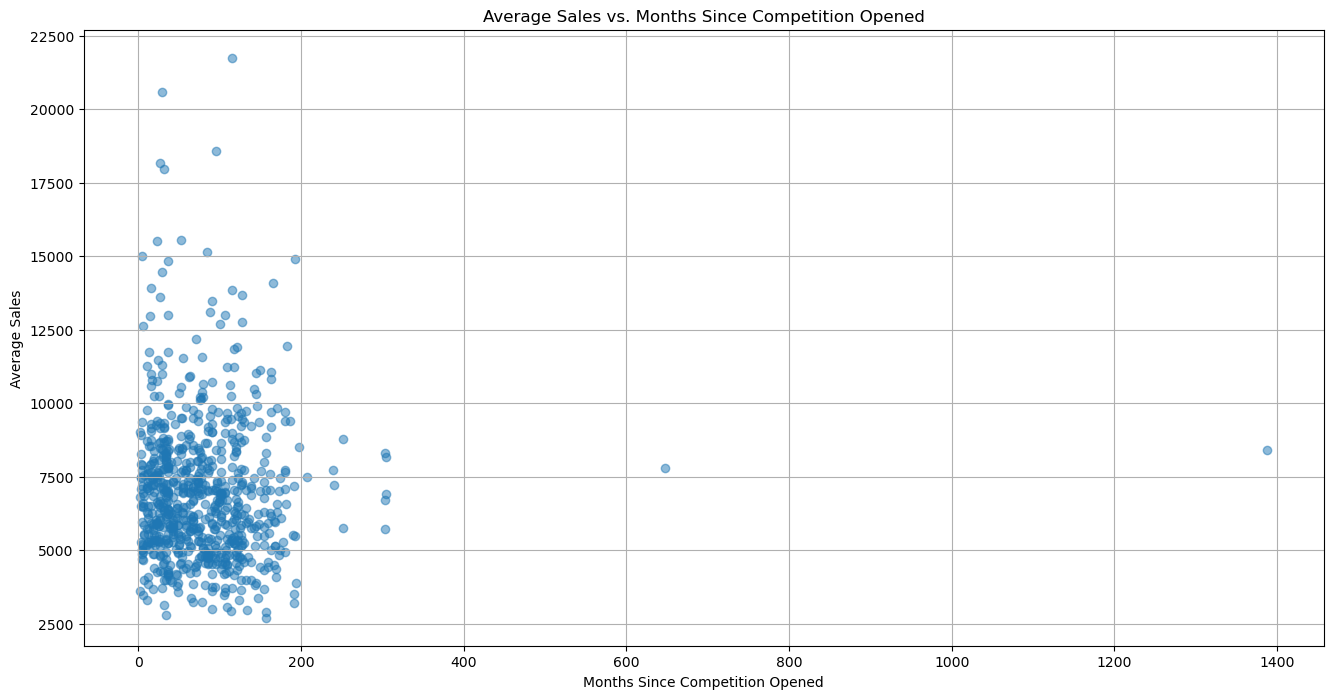

In [43]:
# calculate the average sales for each store
avg_sales_by_store = merged_train.groupby('Store')['Sales'].mean()

# extract the number of months since the nearest competition store opened
months_since_competition_by_store = merged_train.groupby('Store')['MonthsSinceCompetition'].first()

# create the scatter plot
plt.figure(figsize = (16,8))
plt.scatter(months_since_competition_by_store, avg_sales_by_store, alpha = 0.5)
plt.title('Average Sales vs. Months Since Competition Opened')
plt.xlabel('Months Since Competition Opened')
plt.ylabel('Average Sales')
plt.grid(True)
plt.show()

In [44]:
# the correlation between MonthsSinceCompetition and Sales
merged_train['MonthsSinceCompetition'].corr(merged_train['Sales'])

-0.014128383905661476

There is little to no correlation or observable patterns here.

Do the same for customers.

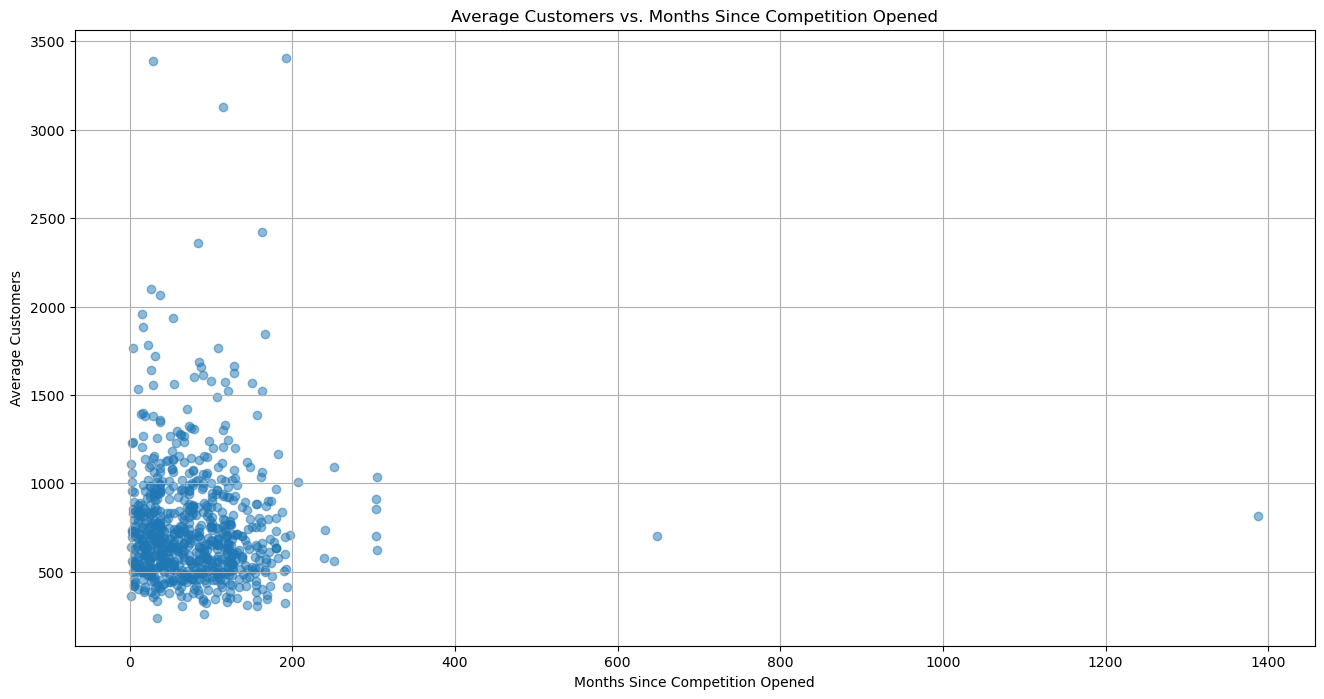

In [45]:
# calculate the average customers for each store
avg_customers_by_store = merged_train.groupby('Store')['Customers'].mean()

# create the scatter plot
plt.figure(figsize = (16,8))
plt.scatter(months_since_competition_by_store, avg_customers_by_store, alpha = 0.5)
plt.title('Average Customers vs. Months Since Competition Opened')
plt.xlabel('Months Since Competition Opened')
plt.ylabel('Average Customers')
plt.grid(True)
plt.show()

In [46]:
# the correlation between MonthsSinceCompetition and Customers
merged_train['MonthsSinceCompetition'].corr(merged_train['Customers'])

-0.008277597437477809

Again, there is little to see here.

Another way to observe the possible effect of competition stores opening, or Promo2 schemes starting, on a stores sales and customer numbers, is observing their effect on one particular store.

For example, store number 28's sales numbers decrease when a nearby competition store opens.

This is not to say that this is always the case, but there are particular cases where this is true. We cannot observe whether this is true for most of the stores, because the dates of their competition stores opening, or their Promo2 schemes starting, lies outside the range for which we have sales/customer numbers.

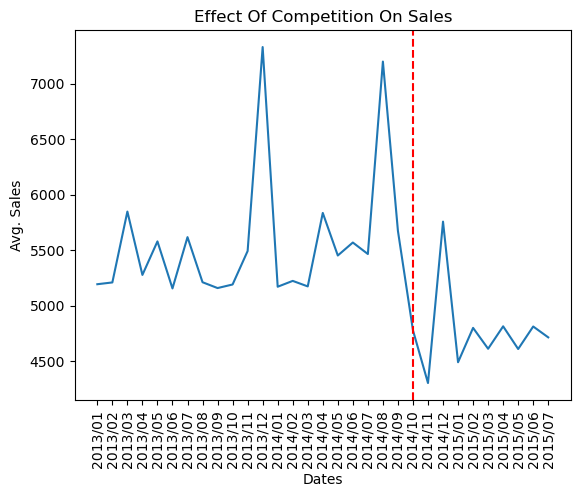

In [47]:
# look at store id 'n'
store_id = 28

# filter to only look at Store n
store_n = merged_train[merged_train['Store'] == store_id]

# calculate the monthly average sales
store_n_dates_sales = store_n.groupby('Date')['Sales'].mean()

# plot the line graph
plt.plot(store_n_dates_sales.index, store_n_dates_sales.values)
plt.xticks(rotation = 90);
plt.title('Effect Of Competition On Sales')
plt.xlabel('Dates');
plt.ylabel('Avg. Sales');

# extract the CompetitionSinceDate for store n
competition_since_date_n = store_n['CompetitionSinceDate'].min()

# plot a red vertical line on this date
plt.axvline(x= competition_since_date_n, color='red', linestyle='--')

plt.show()

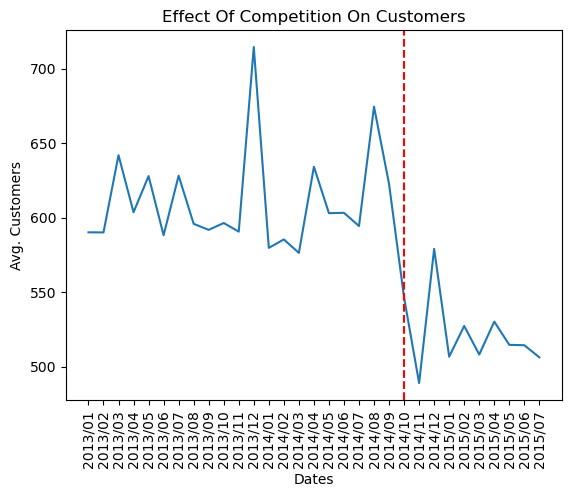

In [48]:
# repeating the same with customers instead of sales

# calculate the monthly average customers
store_n_dates_customers = store_n.groupby('Date')['Customers'].mean()

# plot the line graph
plt.plot(store_n_dates_customers.index, store_n_dates_customers.values)
plt.xticks(rotation = 90);
plt.title('Effect Of Competition On Customers')
plt.xlabel('Dates');
plt.ylabel('Avg. Customers');

# extract the CompetitionSinceDate for store n
competition_since_date_n = store_n['CompetitionSinceDate'].min()

# plot a red vertical line on this date
plt.axvline(x= competition_since_date_n, color='red', linestyle='--')

plt.show()

Again, there are cases where Promo2 increases performance of a shop, but this is not well-reflected on all stores.

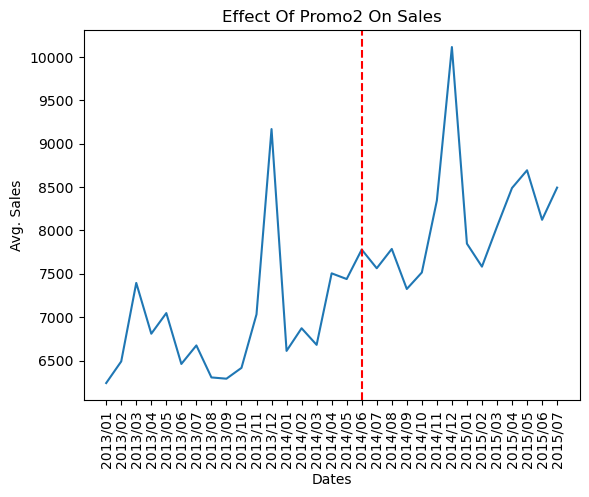

In [49]:
# look at store id 'n'
store_id = 857

# filter to only look at Store n
store_n = merged_train[merged_train['Store'] == store_id]

# calculate the monthly average sales
store_n_dates_sales = store_n.groupby('Date')['Sales'].mean()

# plot the line graph
plt.plot(store_n_dates_sales.index, store_n_dates_sales.values)
plt.xticks(rotation = 90);
plt.title('Effect Of Promo2 On Sales')
plt.xlabel('Dates');
plt.ylabel('Avg. Sales');

# extract the CompetitionSinceDate for store n
promo2_since_date_n = store_n['Promo2SinceDate'].min()

# plot a red vertical line on this date
plt.axvline(x= promo2_since_date_n, color='red', linestyle='--')

plt.show()

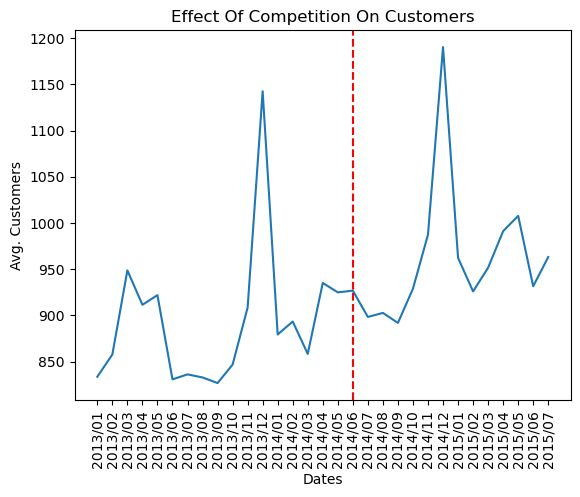

In [50]:
# look at store id 'n'
store_id = 857

# filter to only look at Store n
store_n = merged_train[merged_train['Store'] == store_id]

# calculate the monthly average sales
store_n_dates_customers = store_n.groupby('Date')['Customers'].mean()

# plot the line graph
plt.plot(store_n_dates_customers.index, store_n_dates_customers.values)
plt.xticks(rotation = 90);
plt.title('Effect Of Competition On Customers')
plt.xlabel('Dates');
plt.ylabel('Avg. Customers');

# extract the CompetitionSinceDate for store n
promo2_since_date_n = store_n['Promo2SinceDate'].min()

# plot a red vertical line on this date
plt.axvline(x= promo2_since_date_n, color='red', linestyle='--')

plt.show()

We want to see how CompetitionDistance affects the sales and customer numbers of different stores.

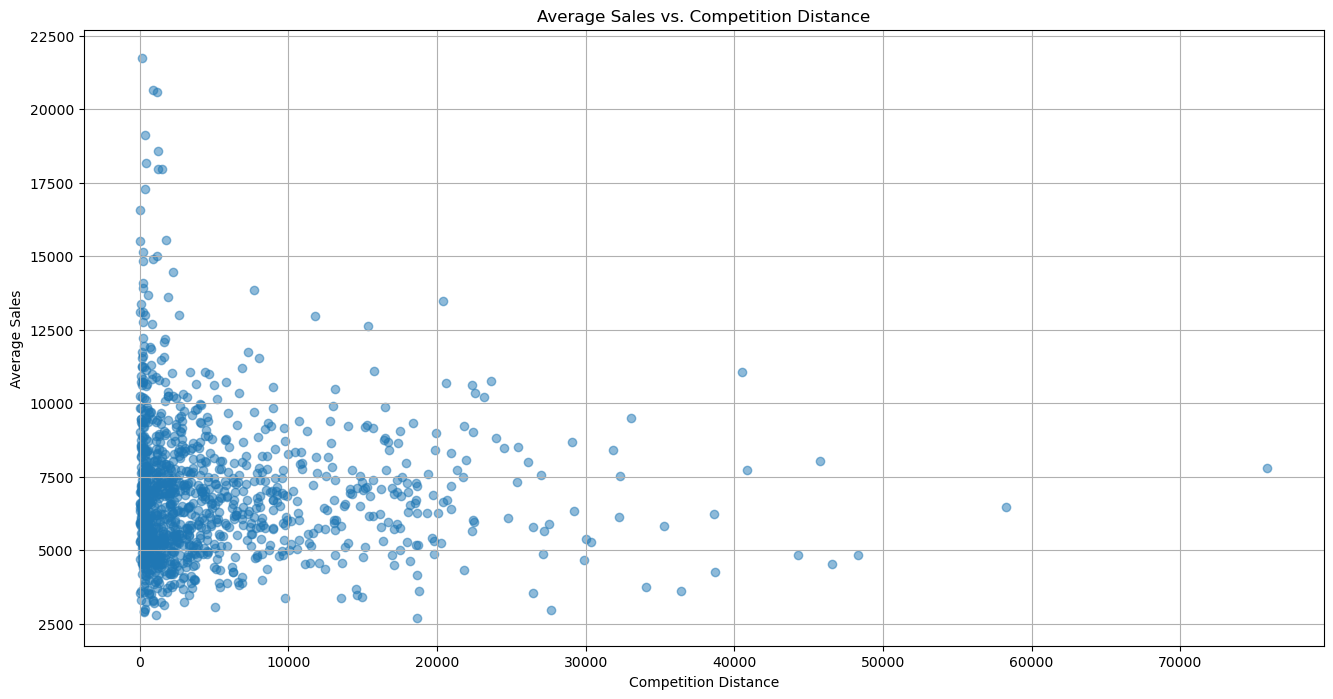

In [51]:
# extract the CompetitionDistance of each store
competition_distance_by_store = merged_train.groupby('Store')['CompetitionDistance'].first()

# create the scatter plot
plt.figure(figsize=(16,8))
# use the avg_sales_by_store calculated earlier
plt.scatter(competition_distance_by_store, avg_sales_by_store, alpha=0.5)
plt.title('Average Sales vs. Competition Distance')
plt.xlabel('Competition Distance')
plt.ylabel('Average Sales')
plt.grid(True)
plt.show()

Intuitively, we would expect average sales to be higher for stores which have greater distance to their competitors. This graph, however, does not suggest this to be the case. The correlation is very weak.

In [52]:
# the correlation between CompetitionDistance and Sales
merged_train['CompetitionDistance'].corr(merged_train['Sales'])

-0.03602765214783232

The same is true for customer numbers.

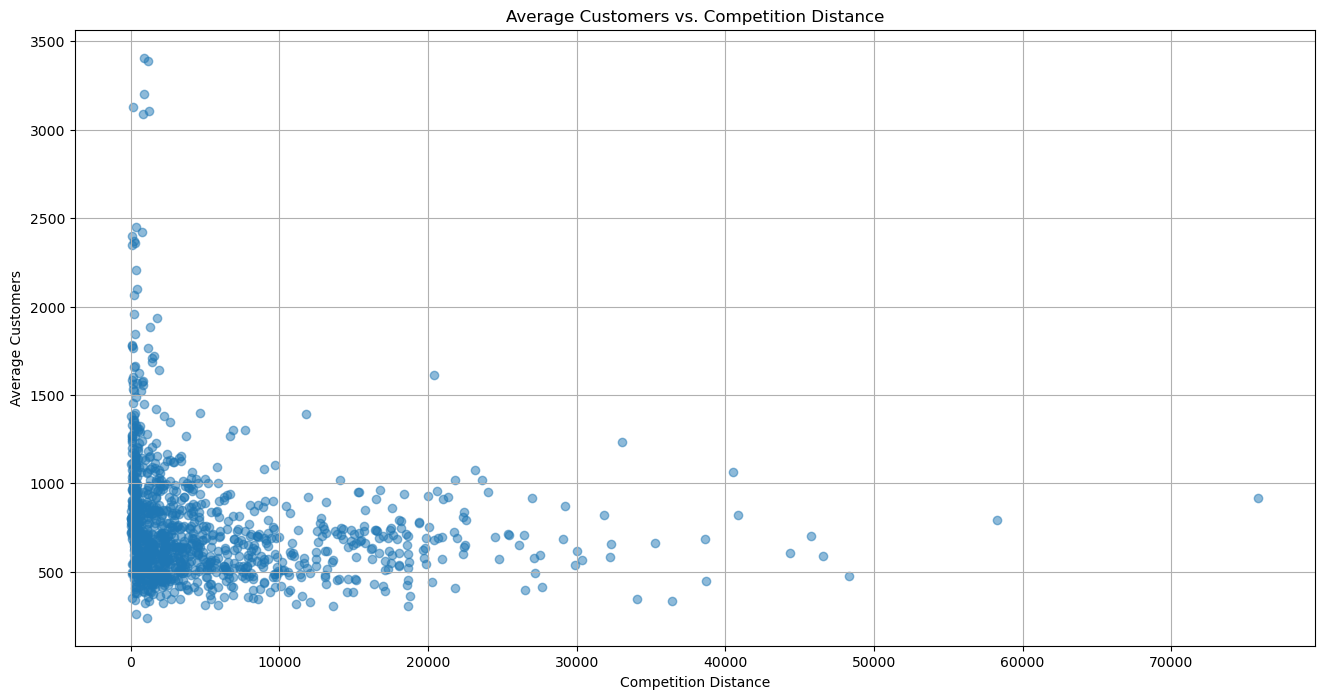

In [53]:
# create the scatter plot
plt.figure(figsize=(16,8))
plt.scatter(competition_distance_by_store, avg_customers_by_store, alpha=0.5)
plt.title('Average Customers vs. Competition Distance')
plt.xlabel('Competition Distance')
plt.ylabel('Average Customers')
plt.grid(True)
plt.show()

In [54]:
# the correlation between CompetitionDistance and Customers
merged_train['CompetitionDistance'].corr(merged_train['Customers'])

-0.14819581828864797

## Preparation for models
At this point, in our merged datasets, we have lots of columns which were useful for visualisations, but will be of no use in our forecasting model. We look to see which columns are worth keeping before we move forward. We also need to use encoding on our categorical variables.

Take a quick look at both of our merged datasets.

In [55]:
merged_train.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Year,Month,StoreType,Assortment,CompetitionDistance,Promo2,CompetitionSinceDate,Promo2SinceDate,MonthsSinceCompetition,MonthsSincePromo2
0,1,5,2015/07,5263,555,1,0,1,2015,07,c,a,1270.0,0,2008/09,NaN,85.0,NaN
1,2,5,2015/07,6064,625,1,0,1,2015,07,a,a,570.0,1,2007/11,2010/04,95.0,66.0
2,3,5,2015/07,8314,821,1,0,1,2015,07,a,a,14130.0,1,2006/12,2011/04,106.0,54.0
3,4,5,2015/07,13995,1498,1,0,1,2015,07,c,c,620.0,0,2009/09,NaN,73.0,NaN
4,5,5,2015/07,4822,559,1,0,1,2015,07,a,a,29910.0,0,2015/04,NaN,6.0,NaN


In [56]:
merged_test.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,StoreType,Assortment,CompetitionDistance,Promo2,CompetitionSinceDate,Promo2SinceDate,MonthsSinceCompetition,MonthsSincePromo2
0,1,4,17/09/2015,NaN,NaN,1.0,1,0,0,2015,09,c,a,1270.0,0,2008/09,NaN,85.0,NaN
1,3,4,17/09/2015,NaN,NaN,1.0,1,0,0,2015,09,a,a,14130.0,1,2006/12,2011/04,106.0,54.0
2,7,4,17/09/2015,NaN,NaN,1.0,1,0,0,2015,09,a,c,24000.0,0,2013/04,NaN,30.0,NaN
3,8,4,17/09/2015,NaN,NaN,1.0,1,0,0,2015,09,a,a,7520.0,0,2014/10,NaN,12.0,NaN
4,9,4,17/09/2015,NaN,NaN,1.0,1,0,0,2015,09,a,c,2030.0,0,2000/08,NaN,182.0,NaN


merged_train has one less column, because we dropped the 'Open' column earlier. 

We now think about which variables we can certainly drop, before thinking about what type of machine learning model we want.

Although we could use 'Date' for some time series analysis, the graphs showing average sales and customer numbers separated by date, suggested that 'Date' showed nothing that 'Year' and 'Month' did not.

The 'CompetitionSinceDate' and 'Promo2SinceDate' columns will not be used, as much of this information is captured in the 'MonthsSinceCompetition' and 'MonthsSincePromo2' columns.

In [57]:
# drop the columns we certainly will not be using
columns = ['Date', 'CompetitionSinceDate', 'Promo2SinceDate']
merged_train.drop(columns, axis = 1, inplace = True)
merged_test.drop(columns, axis = 1, inplace = True)

In [58]:
merged_train.head(5)

,Store,DayOfWeek,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Year,Month,StoreType,Assortment,CompetitionDistance,Promo2,MonthsSinceCompetition,MonthsSincePromo2
0,1,5,5263,555,1,0,1,2015,07,c,a,1270.0,0,85.0,NaN
1,2,5,6064,625,1,0,1,2015,07,a,a,570.0,1,95.0,66.0
2,3,5,8314,821,1,0,1,2015,07,a,a,14130.0,1,106.0,54.0
3,4,5,13995,1498,1,0,1,2015,07,c,c,620.0,0,73.0,NaN
4,5,5,4822,559,1,0,1,2015,07,a,a,29910.0,0,6.0,NaN


We change the categorical variables to integers using label encoding, because this works better with many machine learning models. (In the end, we use XGBoost, which requires this).

In [59]:
merged_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844176 entries, 0 to 844175
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Store                   844176 non-null  int64  
 1   DayOfWeek               844176 non-null  int64  
 2   Sales                   844176 non-null  int64  
 3   Customers               844176 non-null  int64  
 4   Promo                   844176 non-null  int64  
 5   StateHoliday            844176 non-null  object 
 6   SchoolHoliday           844176 non-null  int64  
 7   Year                    844176 non-null  object 
 8   Month                   844176 non-null  object 
 9   StoreType               844176 non-null  object 
 10  Assortment              844176 non-null  object 
 11  CompetitionDistance     844176 non-null  float64
 12  Promo2                  844176 non-null  int64  
 13  MonthsSinceCompetition  575649 non-null  float64
 14  MonthsSincePromo2   

In [60]:
# convert the Month column to integers, without leading zeroes
merged_train['Month'] = merged_train['Month'].str.strip("0")
merged_test['Month'] = merged_train['Month'].str.strip("0")
merged_train['Month'] = merged_train['Month'].astype('int64')
merged_test['Month'] = merged_test['Month'].astype('int64')

# convert StoreType to integers
store_type_mapping = {'a': 1, 'b': 2, 'c': 3, 'd': 4}
merged_train['StoreType'] = merged_train['StoreType'].map(store_type_mapping)
merged_test['StoreType'] = merged_test['StoreType'].map(store_type_mapping)

# convert Assortment to integers
assortment_mapping = {'a': 1, 'b': 2, 'c': 3}
merged_train['Assortment'] = merged_train['Assortment'].map(assortment_mapping)
merged_test['Assortment'] = merged_test['Assortment'].map(assortment_mapping)

# convert Year to integers
merged_train['Year'] = merged_train['Year'].astype('int64')
merged_test['Year'] = merged_test['Year'].astype('int64')

# convert StateHoliday to integers
merged_train['StateHoliday'] = merged_train['StateHoliday'].astype('int64')
merged_test['StateHoliday'] = merged_test['StateHoliday'].astype('int64')

# ensure that categorical variables are treated as such
categorical_columns = ['Store', 'DayOfWeek', 'Promo','StateHoliday','SchoolHoliday','Year','Month','StoreType',
                       'Assortment', 'Promo2']
merged_train[categorical_columns] = merged_train[categorical_columns].astype("category")
merged_test[categorical_columns] = merged_test[categorical_columns].astype("category")

In [61]:
merged_train.head(5)

,Store,DayOfWeek,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Year,Month,StoreType,Assortment,CompetitionDistance,Promo2,MonthsSinceCompetition,MonthsSincePromo2
0,1,5,5263,555,1,0,1,2015,7,3,1,1270.0,0,85.0,NaN
1,2,5,6064,625,1,0,1,2015,7,1,1,570.0,1,95.0,66.0
2,3,5,8314,821,1,0,1,2015,7,1,1,14130.0,1,106.0,54.0
3,4,5,13995,1498,1,0,1,2015,7,3,3,620.0,0,73.0,NaN
4,5,5,4822,559,1,0,1,2015,7,1,1,29910.0,0,6.0,NaN


C:\Users\besso\AppData\Local\Temp\ipykernel_2844\330811879.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = merged_train.corr()


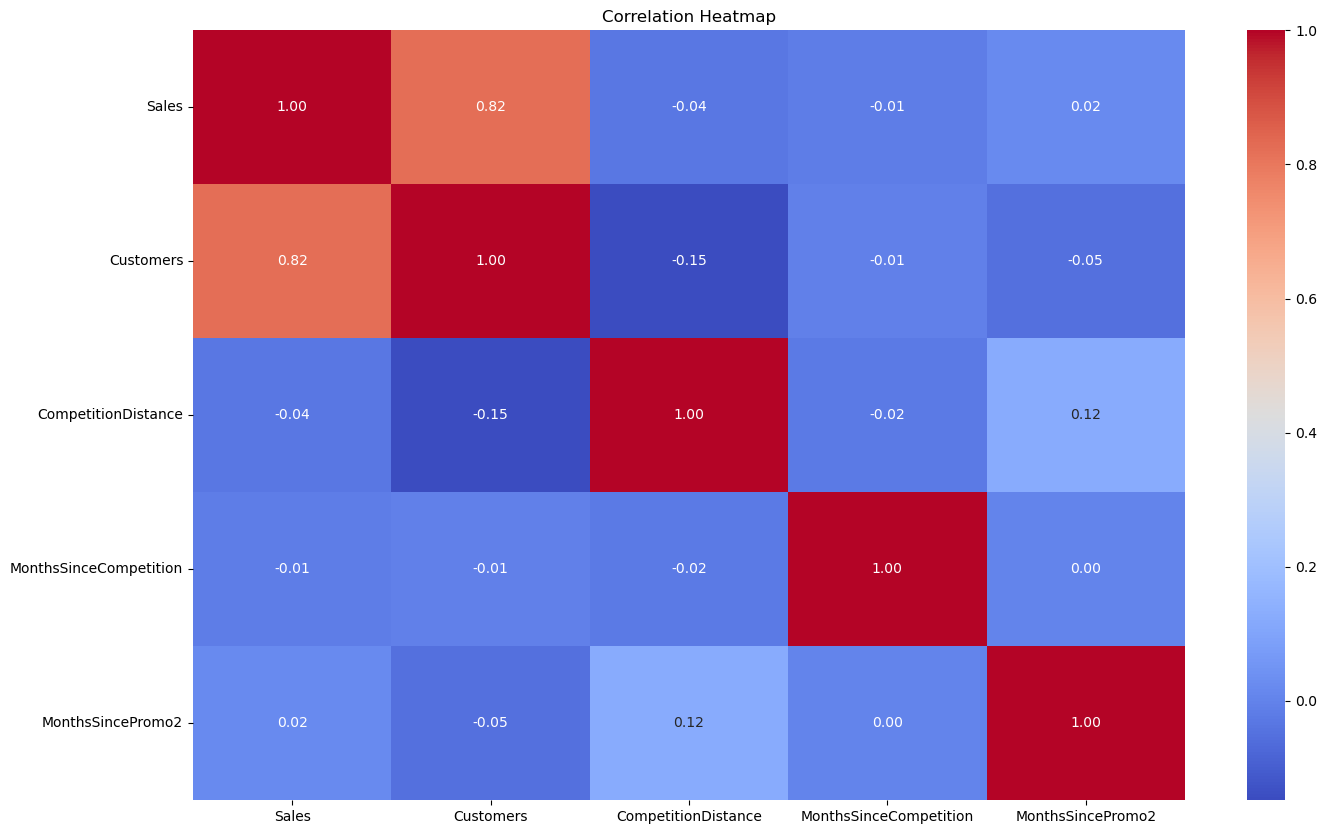

In [62]:
# plotting a correlation matrix
corr_matrix = merged_train.corr()
plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

There is little to no correlation between the target variables (Sales and Customers) and the predictor variables, so a regression model is probably not ideal.

Decision trees would be a good choice. However, since the dataset is not particularly large, random forest can provide greater performance and more stable results. XGBoost is very similar to random forest, but can boast even more accurate results because of its use of gradient boosting. That is what I have decided to use.

## Building the models

In [63]:
## implementing the XGBoost algorithm

# split the training set into predictors and target variables
X = merged_train.drop(['Sales', 'Customers'], axis=1)
y_sales = merged_train['Sales']
y_customers = merged_train['Customers']

# cross validation splits
kf = KFold(n_splits=5, shuffle=True, random_state=23)

# define the models
sales_model = xgb.XGBRegressor(enable_categorical=True)
customers_model = xgb.XGBRegressor(enable_categorical=True)

# train the models
sales_model.fit(X, y_sales)
customers_model.fit(X, y_customers)

# define the evaluation metrics we will use
# RMSE, MAE and R-squared
scoring = {'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
           'neg_mean_absolute_error': 'neg_mean_absolute_error',
           'r2': 'r2'}

# performing cross-validation
sales_cv_results = cross_validate(sales_model, X, y_sales, scoring=scoring, cv=kf)
customers_cv_results = cross_validate(customers_model, X, y_customers, scoring=scoring, cv=kf)

# display the average evaluation metrics
print("Sales RMSE Mean:", -np.mean(sales_cv_results['test_neg_root_mean_squared_error']))
print("Sales MAE Mean:", -np.mean(sales_cv_results['test_neg_mean_absolute_error']))
print("Sales R-squared Mean:", np.mean(sales_cv_results['test_r2']))

print("Customers RMSE Mean:", -np.mean(customers_cv_results['test_neg_root_mean_squared_error']))
print("Customers MAE Mean:", -np.mean(customers_cv_results['test_neg_mean_absolute_error']))
print("Customers R-squared Mean:", np.mean(customers_cv_results['test_r2']))

Sales RMSE Mean: 946.8669928542924
Sales MAE Mean: 633.78712467228
Sales R-squared Mean: 0.90683267954199
Customers RMSE Mean: 86.08912311944172
Customers MAE Mean: 55.55499813211736
Customers R-squared Mean: 0.9538151165450068


This is not amazing performance, but it is decent. Since CompetitionDistance is positively skewed, I tried applying a log transform to it before running the model. A very tiny decrease in performance was seen. Then, I tried dropping CompetitionDistance completely, but this drastically reduced performance. Thus, CompetitionDistance will be kept as is.

Text(0.5, 1.0, 'Distribution of CompetitionDistance')

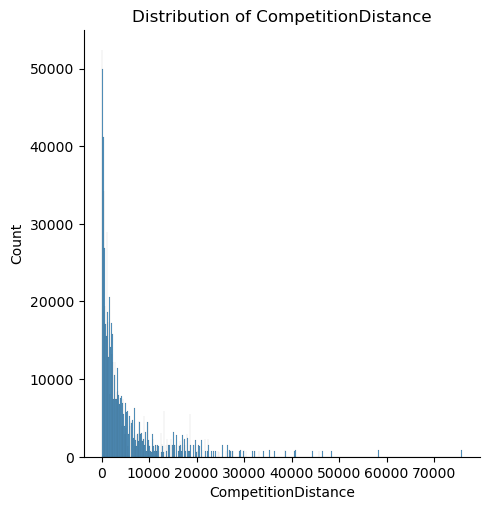

In [64]:
sns.displot(merged_train['CompetitionDistance'])
plt.title('Distribution of CompetitionDistance')

I also tried seeing whether simplifying the Month column to a December column, containing 1s for records in December, and 0s otherwise, helped performance. However, this was not the case.

Looking back in hindsight, there were not many more useful features we could have added. However, we could have looked at using time series analysis in order to get a better result.

## Predicting values

We now look at predicting the values in the given dataset.

In [65]:
# setup
# remember to drop 'Open' column so the dimensions match
X_test = merged_test.drop(['Sales', 'Customers', 'Open'], axis=1)

# making predictions
sales_predictions = sales_model.predict(X_test)
customers_predictions = customers_model.predict(X_test)

# add these predictions to the merged_test dataset
merged_test['Sales'] = sales_predictions
merged_test['Customers'] = customers_predictions

# ensure that records where the stores are closed have 0 sales and 0 customers!
merged_test.loc[merged_test['Open'] == 0, ['Sales', 'Customers']] = 0

In [66]:
merged_test.head(20)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,StoreType,Assortment,CompetitionDistance,Promo2,MonthsSinceCompetition,MonthsSincePromo2
0,1,4,5266.109863,590.288513,1.0,1,0,0,2015,7,3,1,1270.0,0,85.0,NaN
1,3,4,5341.725098,609.779297,1.0,1,0,0,2015,7,1,1,14130.0,1,106.0,54.0
2,7,4,7673.656738,813.476318,1.0,1,0,0,2015,7,1,3,24000.0,0,30.0,NaN
3,8,4,9542.491211,1343.858276,1.0,1,0,0,2015,7,1,1,7520.0,0,12.0,NaN
4,9,4,5115.833496,598.013794,1.0,1,0,0,2015,7,1,3,2030.0,0,182.0,NaN
5,10,4,6702.962402,768.381226,1.0,1,0,0,2015,7,1,1,3160.0,0,73.0,NaN
6,11,4,8404.806641,901.437866,1.0,1,0,0,2015,7,1,3,960.0,1,47.0,45.0
7,12,4,6230.945801,767.471497,1.0,1,0,0,2015,7,1,3,1070.0,1,NaN,66.0
8,13,4,5213.086914,501.691986,1.0,1,0,0,2015,7,4,1,310.0,1,NaN,71.0
9,14,4,5546.903320,588.964111,1.0,1,0,0,2015,7,1,1,1300.0,1,19.0,48.0
